# Install Dartnet

In [ ]:
# Install reference:
##  https://colab.research.google.com/drive/1fIK6g2oYyMrNheEmtVObWgU1JMrOv_e8?usp=sharing
##  https://github.com/kriyeng/darknet
# Testing reference:
## https://hi-upchen.medium.com/如何在-colab-安裝-darknet-框架訓練-yolo-v3-物件辨識並且最佳化-colab-的訓練流程-e5ded7bbab00

total 422770
-rw------- 1 root root 432811879 Nov 11 03:46 cudnn-10.0-linux-x64-v7.5.0.56.tgz
-rw------- 1 root root    103838 Nov 11 05:21 hw2_0716085_nctu.ipynb


In [ ]:
""" Check Hardware info """
!nvcc -V # Check the CUDA version
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2 # Check the cudnn version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 5
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
""" Download and compile darknet """
!git clone https://github.com/AlexeyAB/darknet.git darknet_repo
%cd darknet_repo
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
!sed -i "s/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= ${ARCH_VALUE}/g" Makefile
!make

Cloning into 'darknet_repo'...
remote: Enumerating objects: 15339, done.
remote: Counting objects: 100% (15339/15339), done.
remote: Compressing objects: 100% (4695/4695), done.
remote: Total 15339 (delta 10317), reused 15337 (delta 10315), pack-reused 0
Receiving objects: 100% (15339/15339), 13.96 MiB | 15.94 MiB/s, done.
Resolving deltas: 100% (10317/10317), done.
/content/darknet_repo
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-b

In [ ]:
""" move executable file and relative file to home dir """
!cp ./darknet /content
!cp -r cfg/ /content
# !cp -r data/ /content
%cd /content
!ls -l

/content
total 5460
drwxr-xr-x  3 root root    4096 Nov 11 05:52 cfg
-rwxr-xr-x  1 root root 5567288 Nov 11 05:52 darknet
drwxr-xr-x 16 root root    4096 Nov 11 05:51 darknet_repo
drwxr-xr-x  3 root root    4096 Nov 11 05:52 data
drwx------  6 root root    4096 Nov 11 05:48 drive
drwxr-xr-x  1 root root    4096 Nov  1 13:35 sample_data


In [ ]:
""" Testing the installation of dartnet (GPU required) """
!wget https://pjreddie.com/media/files/yolov3.weights
!./darknet detector test cfg/coco.data cfg/yolov3.cfg yolov3.weights darknet_repo/data/person.jpg -dont-show
import cv2
from matplotlib import pyplot as plt
im = cv2.imread("predictions.jpg", cv2.IMREAD_UNCHANGED) # cv2.IMREAD_COLOR to ignore Transparency
im = im[:,:,::-1] # cv2 BGR image to RGB image
fig = plt.figure()
plt.imshow(im)
plt.show()

--2021-11-11 05:52:46--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  34.6MB/s    in 7.4s    

2021-11-11 05:52:54 (31.9 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



# read training data

In [ ]:
""" Unzip training data """
!unzip /content/drive/MyDrive/VRDL/hw2/train.zip -d ./

In [16]:
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

from matplotlib import patches
from matplotlib import pyplot as plt
from scipy.io import loadmat, savemat
import os, sys, cv2
import numpy as np

BASE_DIR = "/content/drive/MyDrive/VRDL/hw2/"

In [23]:
file_names = os.listdir("train")
for fname in file_names:
    if not "png" in fname:
        print(fname)
    else:
        img = cv2.imread(train + fname)

see_bboxes.m
digitStruct.mat


In [14]:
""" Load my DigitStruct.amt """
DigitStruct = loadmat(BASE_DIR + "digitStruct.mat")
# DigitStruct = { image_name: [ [height, left, top, width, label], [], ... ], ... }

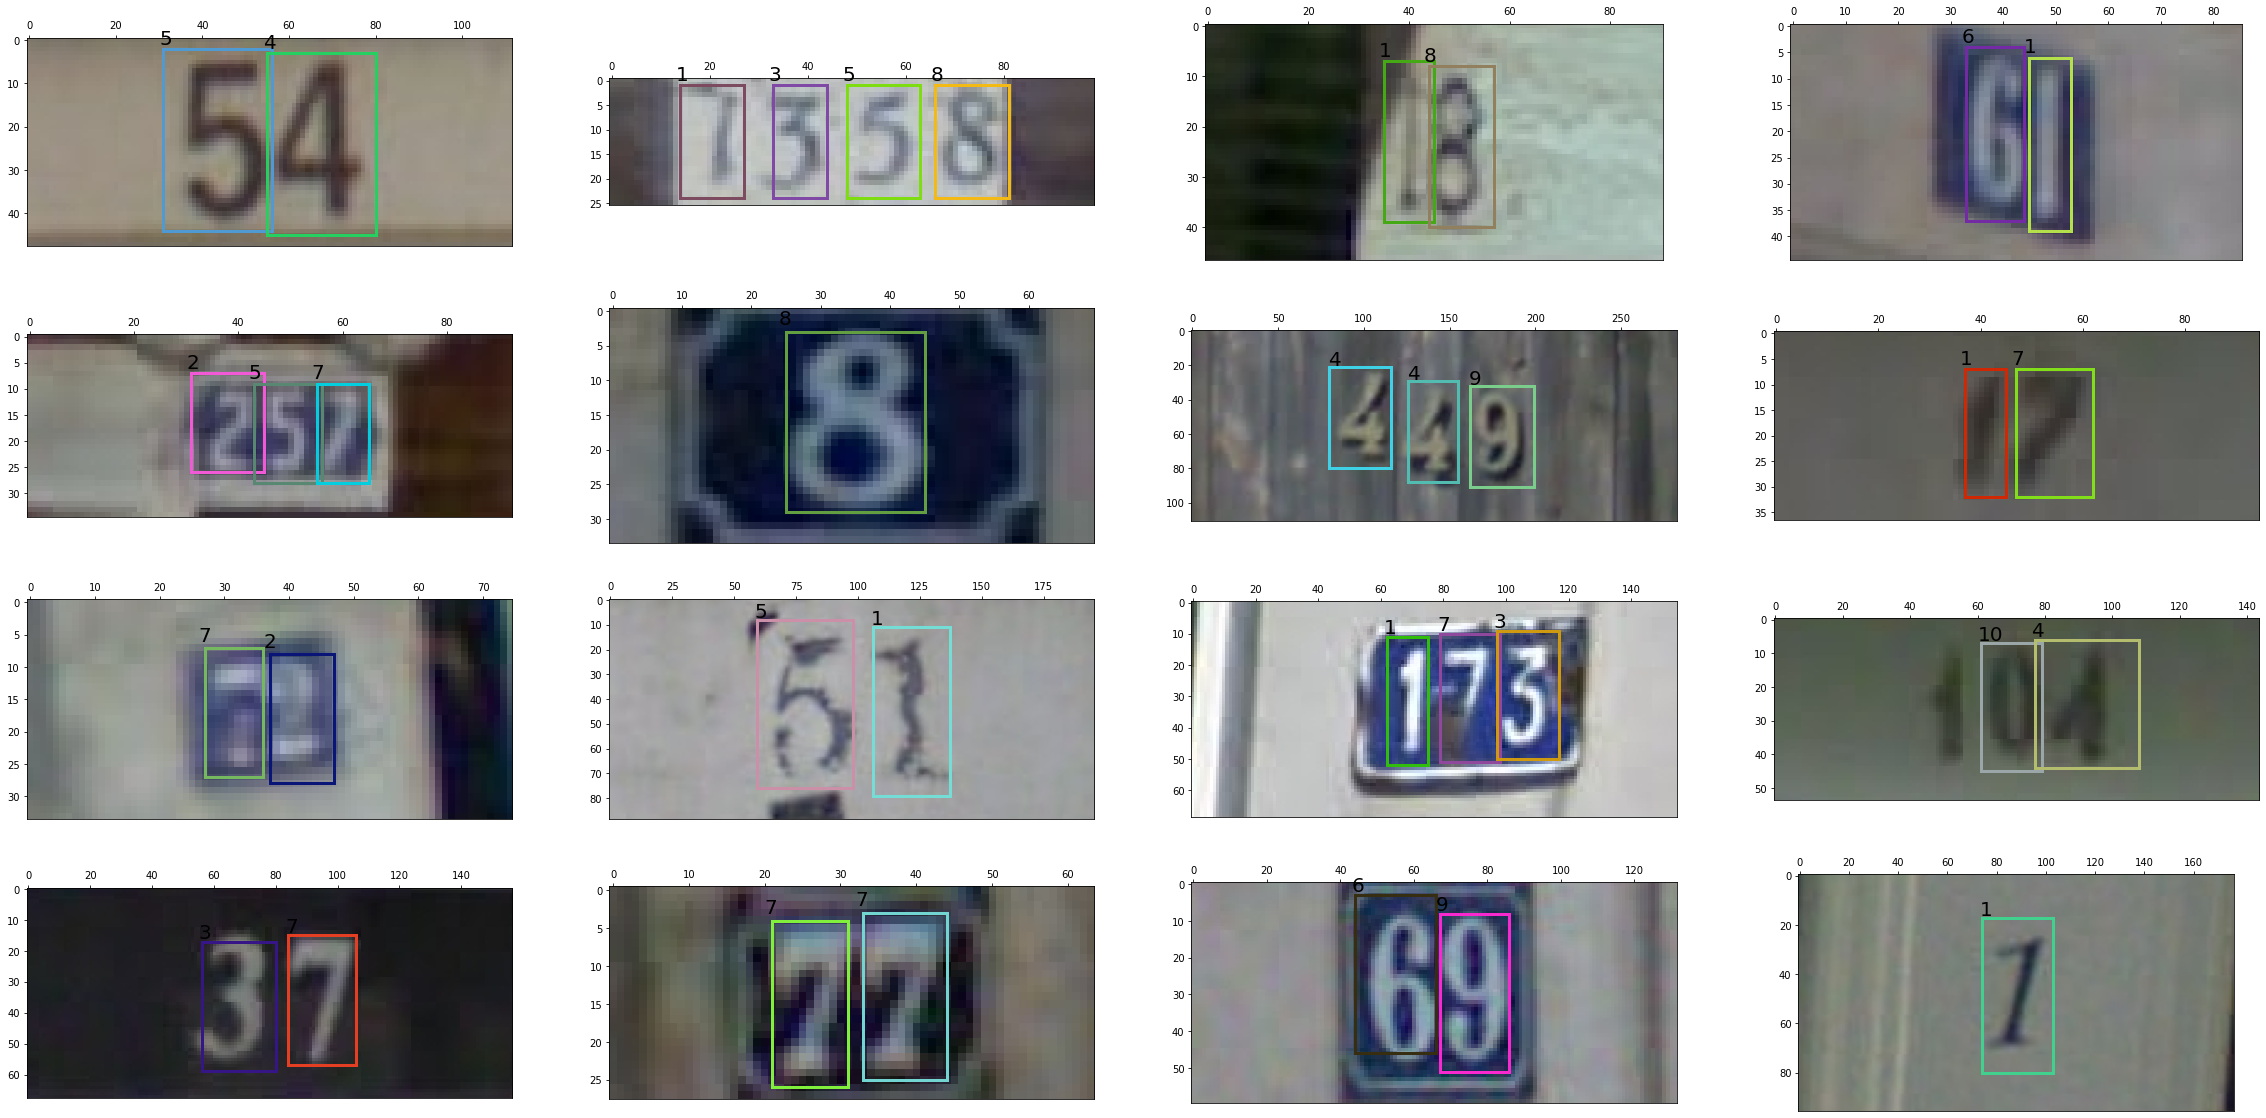

In [37]:
""" Plot 16 random samples """
fig = plt.figure(figsize=(40, 20))
for px in range(16):
    fname = f"{np.random.randint(len(DigitStruct) - 3) + 1}.png"
    im = cv2.imread("train/" + fname)
    im = im[:,:,::-1] # cv2 BGR image to RGB image
    bbox = DigitStruct[fname]
    ax = plt.subplot(4, 4, px + 1)
    ax.xaxis.tick_top()
    ax.imshow(im)
    for i in range(bbox.shape[0]):
        x = bbox[i][1]
        y = bbox[i][2]
        w = bbox[i][3]
        h = bbox[i][0]
        ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor=np.random.rand(3), lw=3))
        ax.text(x - 1, y - 1, bbox[i][4], fontsize=20)
plt.show()